# Fall Detection — SHIRT POCKET Mode
**MPU6050 placement: Shirt breast pocket (waist level)**

---
## Dataset: FallAllD (Waist device)
| Item | Detail |
|------|--------|
| **File** | `data/FallAllD/FallAllD_40SamplesPerSec_ActivityIdsFiltered.pkl` |
| **Device** | `Waist` (closest to shirt breast pocket) |
| **Falls** | ActivityID 101–135 (35 fall types) |
| **ADL** | ActivityID 1–100 |
| **Sampling** | Already 40 Hz |
| **Window** | 80 samples = 2 s @ 40 Hz |
| **Format** | Each row: `Acc` array (N,3), `Gyr` array (N,3) in raw sensor units |

In [1]:
import os, pickle, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from autogluon.tabular import TabularPredictor
warnings.filterwarnings('ignore')

PLACEMENT    = 'SHIRT'
PKL_FILE     = 'data/FallAllD/FallAllD_40SamplesPerSec_ActivityIdsFiltered.pkl'
DEVICE       = 'Waist'
SAMPLE_RATE  = 40
WINDOW_SIZE  = 80
STEP_SIZE    = 40
RANDOM_STATE = 42
FALL_START   = 101
os.makedirs('models', exist_ok=True)
print(f'Config: {PLACEMENT}, {SAMPLE_RATE} Hz, {WINDOW_SIZE/SAMPLE_RATE}s window')

Config: SHIRT, 40 Hz, 2.0s window


/Users/frank/Vscode/Hardware-Project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load FallAllD

In [2]:
with open(PKL_FILE, 'rb') as f:
    all_data = pickle.load(f)

df_waist = all_data[all_data['Device'] == DEVICE].copy()
df_waist['label'] = (df_waist['ActivityID'] >= FALL_START).astype(int)
print(f'Waist rows: {len(df_waist):,}')
print(f'Falls (ActivityID>=101): {df_waist.label.sum():,}')
print(f'ADL  (ActivityID< 101): {(df_waist.label==0).sum():,}')
sample_acc = df_waist.iloc[0]['Acc']
print(f'Acc shape per row: {sample_acc.shape}  (samples x 3 axes)')
print(f'Acc magnitude mean (first ADL): {np.sqrt((df_waist[df_waist.label==0].iloc[0]["Acc"]**2).sum(axis=1)).mean():.0f} raw units')

Waist rows: 1,706
Falls (ActivityID>=101): 374
ADL  (ActivityID< 101): 1,332
Acc shape per row: (800, 3)  (samples x 3 axes)
Acc magnitude mean (first ADL): 4061 raw units


## 2. Signal Visualization

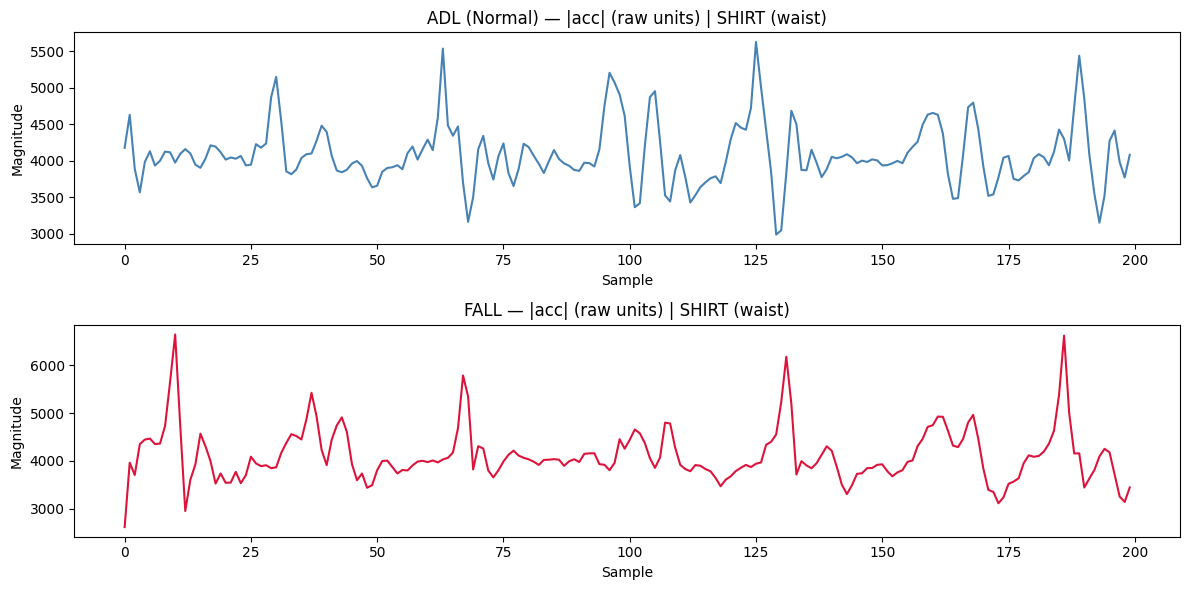

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
for ax_p, lbl, color, title in zip(
        axes, [0, 1], ['steelblue', 'crimson'], ['ADL (Normal)', 'FALL']):
    row = df_waist[df_waist['label'] == lbl].iloc[0]
    acc = row['Acc']
    mag = np.sqrt((acc**2).sum(axis=1))[:200]
    ax_p.plot(mag, color=color)
    ax_p.set_title(f'{title} — |acc| (raw units) | {PLACEMENT} (waist)')
    ax_p.set_ylabel('Magnitude'); ax_p.set_xlabel('Sample')
plt.tight_layout()
plt.savefig(f'models/{PLACEMENT}_signal.png', dpi=150)
plt.show()

## 3. Feature Extraction — 23 Features

In [4]:
def extract_features(window, fs=SAMPLE_RATE):
    ax, ay, az = window[:, 0], window[:, 1], window[:, 2]
    mag   = np.sqrt(ax**2 + ay**2 + az**2)
    mag_c = mag - np.mean(mag)
    freqs = fftfreq(len(mag), 1/fs)
    fmag  = np.abs(fft(mag))[:len(mag)//2]
    pf    = freqs[:len(mag)//2]
    jerk  = np.diff(mag) * fs
    f  = [float(np.mean(ax)), float(np.mean(ay)), float(np.mean(az))]
    f += [float(np.std(ax)),  float(np.std(ay)),  float(np.std(az))]
    f += [float(np.min(mag)), float(np.max(mag)), float(np.ptp(mag))]
    f += [float(np.sqrt(np.mean(ax**2))), float(np.sqrt(np.mean(ay**2))), float(np.sqrt(np.mean(az**2)))]
    f += [float(stats.skew(mag)), float(stats.kurtosis(mag))]
    f.append(float(np.sum(np.diff(np.sign(mag_c)) != 0)))
    f.append(float(np.sum(np.abs(ax)+np.abs(ay)+np.abs(az)) / len(ax)))
    f.append(float(pf[np.argmax(fmag)]) if len(fmag) > 0 else 0.0)
    f.append(float(np.sum(fmag**2)))
    f.append(float(np.corrcoef(ax, ay)[0,1]) if np.std(ax)>0 and np.std(ay)>0 else 0.0)
    f.append(float(np.corrcoef(ay, az)[0,1]) if np.std(ay)>0 and np.std(az)>0 else 0.0)
    f.append(float(np.corrcoef(ax, az)[0,1]) if np.std(ax)>0 and np.std(az)>0 else 0.0)
    f.append(float(np.max(np.abs(jerk))) if len(jerk)>0 else 0.0)
    f.append(float(np.var(mag)))
    assert len(f) == 23
    return np.array(f, dtype=np.float32)

FEATURE_NAMES = [
    'mean_ax','mean_ay','mean_az','std_ax','std_ay','std_az',
    'min_mag','max_mag','range_mag','rms_ax','rms_ay','rms_az',
    'skewness','kurtosis','zero_cross','SMA',
    'dom_freq','spectral_energy','corr_xy','corr_yz','corr_xz',
    'max_jerk','acc_variance',
]
print(f'{len(FEATURE_NAMES)} features')

23 features


In [5]:
def build_feature_df(df, win=WINDOW_SIZE, step=STEP_SIZE):
    rows = []
    for _, row in df.iterrows():
        acc   = row['Acc'].astype(np.float32)
        label = int(row['label'])
        for s in range(0, len(acc) - win, step):
            rows.append(np.append(extract_features(acc[s:s+win]), label))
    result = pd.DataFrame(rows, columns=FEATURE_NAMES + ['label'])
    result['label'] = result['label'].astype(int)
    return result

print('Extracting features...')
feat_df = build_feature_df(df_waist)
print(f'Windows: {len(feat_df):,} | Falls: {feat_df.label.sum():,} ({feat_df.label.mean()*100:.1f}%) | ADL: {(feat_df.label==0).sum():,}')
feat_df.head(3)

Extracting features...
Windows: 30,708 | Falls: 6,732 (21.9%) | ADL: 23,976


,mean_ax,mean_ay,mean_az,std_ax,std_ay,std_az,min_mag,max_mag,range_mag,rms_ax,...,zero_cross,SMA,dom_freq,spectral_energy,corr_xy,corr_yz,corr_xz,max_jerk,acc_variance,label
0,3853.602051,-1186.545532,-142.021225,318.389160,369.615204,473.537872,3160.937988,5538.012695,2377.074707,3866.732422,...,22.0,5481.917480,0.0,1.067845e+11,-0.067155,-0.170616,-0.189104,42164.667969,110631.703125,0
1,3798.260498,-1272.063477,165.499069,403.373535,370.763245,294.199463,3160.937988,5538.012695,2377.074707,3819.619385,...,19.0,5350.922852,0.0,1.047713e+11,-0.105342,0.402848,-0.270065,42164.667969,176990.718750,0
2,3859.153076,-1274.434326,81.441719,446.252502,388.971985,249.401321,2985.322998,5629.141113,2643.818115,3884.868652,...,14.0,5342.484375,0.0,1.077231e+11,-0.059396,0.451328,-0.295708,36247.265625,209515.296875,0


## 4. Train with AutoGluon

In [6]:
train_df, test_df = train_test_split(
    feat_df, test_size=0.2, random_state=RANDOM_STATE, stratify=feat_df['label'])
print(f'Train: {len(train_df):,}  |  Test: {len(test_df):,}')

predictor = TabularPredictor(
    label='label', eval_metric='f1',
    path=f'models/{PLACEMENT}_autogluon', verbosity=2,
).fit(train_data=train_df, presets='medium_quality', time_limit=300)

Verbosity: 2 (Standard Logging)
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.13.5
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.0.0: Mon Aug 12 20:54:26 PDT 2024; root:xnu-11215.1.10~2/RELEASE_ARM64_T8112
CPU Count:          8
Pytorch Version:    Can't import torch
CUDA Version:       Can't get cuda version from torch
Memory Avail:       5.91 GB / 24.00 GB (24.6%)
Disk Space Avail:   583.90 GB / 926.35 GB (63.0%)
Presets specified: ['medium_quality']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/Users/frank/Vscode/Hardware-Project/ML/models/SHIRT_autogluon"
Train Data Rows:    24566
Train Data Columns: 23
Label Column:       label
AutoGluon in

Train: 24,566  |  Test: 6,142


	Fitting with cpus=8, gpus=0, mem=0.0/5.9 GB
		`import lightgbm` failed. A quick tip is to install via `pip install autogluon.tabular[lightgbm]==1.5.0`.
Fitting model: LightGBM ... Training model for up to 299.83s of the 299.83s of remaining time.
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
	Fitting with cpus=8, gpus=0, mem=0.0/5.9 GB
		`import lightgbm` failed. A quick tip is to install via `pip install autogluon.tabular[lightgbm]==1.5.0`.
Fitting model: RandomForestGini ... Training model for up to 299.77s of the 299.77s of remaining time.
	Failed to import torch or check CUDA availability!Please ensure you have the correct version of PyTorch installed by running `pip install -U torch`
	Fitting with cpus=8, gpus=0, mem=0.1/5.9 GB
	0.7841	 = Validation score   (f1)
	3.92s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForestEntr ... Training model for up to

## 5. Evaluation

=== SHIRT — Test Results ===
              precision    recall  f1-score   support

         ADL       0.96      0.95      0.96      4796
        FALL       0.84      0.86      0.85      1346

    accuracy                           0.93      6142
   macro avg       0.90      0.91      0.90      6142
weighted avg       0.93      0.93      0.93      6142

AUC-ROC: 0.9757

=== Leaderboard ===
              model  score_test  score_val
WeightedEnsemble_L2    0.848507   0.787350
     ExtraTreesGini    0.847994   0.773626
     ExtraTreesEntr    0.844904   0.784228
   RandomForestEntr    0.843109   0.768398
   RandomForestGini    0.838498   0.784103


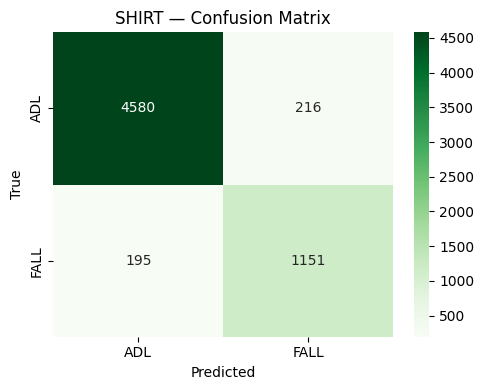

In [7]:
y_test = test_df['label']
y_pred = predictor.predict(test_df)
y_prob = predictor.predict_proba(test_df)[1]

print(f'=== {PLACEMENT} — Test Results ===')
print(classification_report(y_test, y_pred, target_names=['ADL','FALL']))
auc = roc_auc_score(y_test, y_prob)
print(f'AUC-ROC: {auc:.4f}')

lb = predictor.leaderboard(test_df, silent=True)
print('\n=== Leaderboard ===')
print(lb[['model','score_test','score_val']].to_string(index=False))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['ADL','FALL'], yticklabels=['ADL','FALL'])
plt.title(f'{PLACEMENT} — Confusion Matrix')
plt.ylabel('True'); plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f'models/{PLACEMENT}_confusion.png', dpi=150)
plt.show()

## 6. Save Results

In [8]:
results = {
    'placement': PLACEMENT, 'dataset': 'FallAllD-Waist',
    'n_windows': len(feat_df), 'n_features': len(FEATURE_NAMES),
    'test_f1': float(f1_score(y_test, y_pred)),
    'precision': float(precision_score(y_test, y_pred)),
    'recall': float(recall_score(y_test, y_pred)),
    'auc': float(auc),
    'best_model': lb.iloc[0]['model'] if len(lb) > 0 else 'unknown',
}
pd.DataFrame([results]).to_csv(f'models/{PLACEMENT}_results.csv', index=False)
print(f'Saved models/{PLACEMENT}_results.csv')
for k,v in results.items(): print(f'  {k}: {v}')

Saved models/SHIRT_results.csv
  placement: SHIRT
  dataset: FallAllD-Waist
  n_windows: 30708
  n_features: 23
  test_f1: 0.8485071876151862
  precision: 0.8419897585954645
  recall: 0.8551263001485884
  auc: 0.9756876241593105
  best_model: WeightedEnsemble_L2
